In [5]:
!pip install -q -U watermark
!pip install -qq transformers

In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.1.0+cu118
transformers: 4.35.0



In [7]:
from google.colab import drive
import pandas as pd

#drive.mount('/drive')

In [8]:
import os

#os.chdir("/drive/MyDrive/inflation_reports")
#os.getcwd()

In [9]:
print(os.listdir() )

['.config', 'data (1).csv', 'sample_data']


In [11]:
path = "/content/data (1).csv"
df = pd.read_csv(path, encoding='latin-1')

In [12]:
df.head()

,sentiment,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [13]:
df.shape

(4846, 2)

In [14]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   sentence   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [15]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [18]:
sns.countplot(df.sentiment)
plt.xlabel('Sentiment');

ValueError: ignored

In [19]:
def to_sentiment(rating):

  if rating == 'negative':
    return 0
  elif rating == 'neutral':
    return 1
  elif rating == 'positive':
    return 2

df['score'] = df.sentiment.apply(to_sentiment)

In [20]:
PRE_TRAINED_MODEL_NAME = 'ProsusAI/finbert'
#PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [21]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)

In [22]:
token_lens = []
print(df.sentence)

#store the token length of each sentence
# word to vec
for txt in df.sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0       According to Gran , the company has no plans t...
1       Technopolis plans to develop in stages an area...
2       The international electronic industry company ...
3       With the new production plant the company woul...
4       According to the company 's updated strategy f...
                              ...                        
4841    LONDON MarketWatch -- Share prices ended lower...
4842    Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843    Operating profit fell to EUR 35.4 mn from EUR ...
4844    Net sales of the Paper segment decreased to EU...
4845    Sales in Finland decreased by 10.5 % in Januar...
Name: sentence, Length: 4846, dtype: object


<ipython-input-23-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


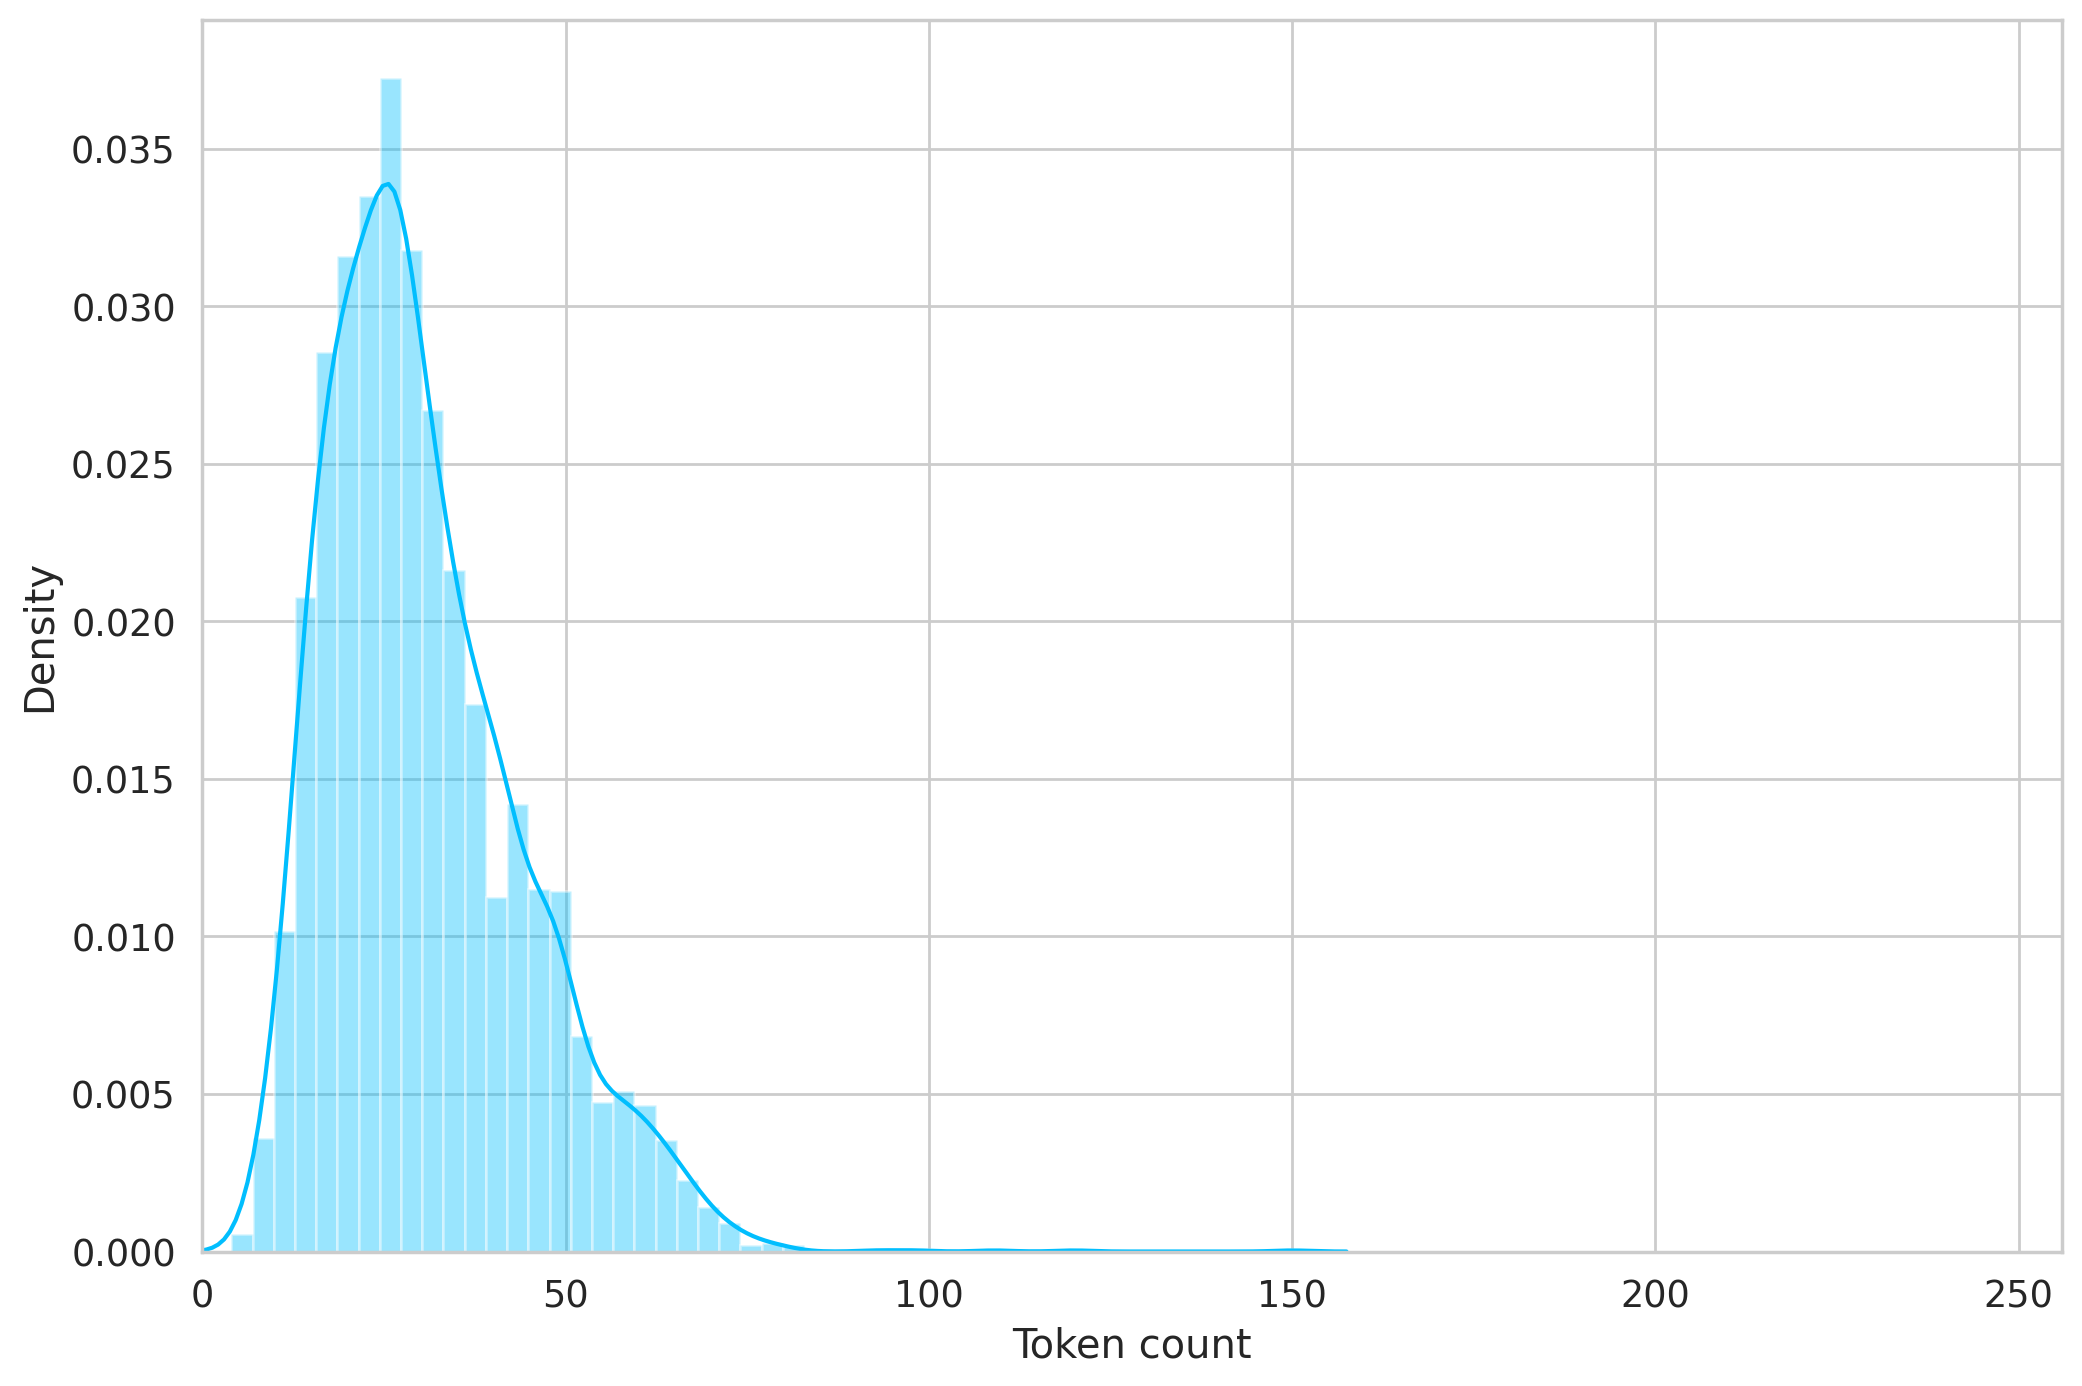

In [23]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [24]:
MAX_LEN = 160

In [25]:
class GPReviewDataset(Dataset):

  def __init__(self, sentences, labels, tokenizer, max_len):
    self.sentences = sentences
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding = 'max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'financiar_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }

In [26]:
# split the data
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((3876, 3), (485, 3), (485, 3))

In [27]:
# create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    sentences=df.sentence.to_numpy(),
    labels=df.score.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )


  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [28]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [29]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['financiar_text', 'input_ids', 'attention_mask', 'label'])

In [30]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [31]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)

for param in bert_model.parameters():
    param.requires_grad = False

In [32]:
#create a classifier that uses the BERT model
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)
    for param in self.bert.parameters():
        param.requires_grad = False
    print(self.bert.config.hidden_size);
    self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 128), # set not trainable
            nn.ReLU(),
            nn.Linear(128, 3)
        )


  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #print(attention_mask,input_ids)
    return self.classifier(pooled_output)

In [33]:
class_names = ['negative', 'neutral', 'positive']
# create an instance and move it to the GPU
model = SentimentClassifier(len(class_names))
model = model.to(device)

768


In [34]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [35]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3399, 0.3086, 0.3515],
        [0.3409, 0.3017, 0.3574],
        [0.3243, 0.3183, 0.3575],
        [0.3661, 0.2990, 0.3350],
        [0.3446, 0.3173, 0.3381],
        [0.3434, 0.3145, 0.3421],
        [0.3508, 0.3001, 0.3491],
        [0.3481, 0.3050, 0.3469],
        [0.3415, 0.2935, 0.3650],
        [0.3689, 0.2898, 0.3413],
        [0.3496, 0.3016, 0.3488],
        [0.3290, 0.3067, 0.3643],
        [0.3686, 0.3119, 0.3195],
        [0.3313, 0.2907, 0.3779],
        [0.3514, 0.3124, 0.3362],
        [0.3538, 0.2934, 0.3528]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [36]:
# Training

# BERT recommendations for fine-tuning:

# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4

# increasing the batch size reduces the training time significantly, but gives you lower accuracy

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
!pip install torch-summary

from torchsummary import summary

In [40]:
# print network summary
summary(model,input_size=(768,),depth=5,batch_dim=1, dtypes=['torch.IntTensor'])

Layer (type:depth-idx)                                  Param #
├─BertModel: 1-1                                        --
|    └─BertEmbeddings: 2-1                              --
|    |    └─Embedding: 3-1                              (23,440,896)
|    |    └─Embedding: 3-2                              (393,216)
|    |    └─Embedding: 3-3                              (1,536)
|    |    └─LayerNorm: 3-4                              (1,536)
|    |    └─Dropout: 3-5                                --
|    └─BertEncoder: 2-2                                 --
|    |    └─ModuleList: 3-6                             --
|    |    |    └─BertLayer: 4-1                         --
|    |    |    |    └─BertAttention: 5-1                (2,363,904)
|    |    |    |    └─BertIntermediate: 5-2             (2,362,368)
|    |    |    |    └─BertOutput: 5-3                   (2,361,600)
|    |    |    └─BertLayer: 4-2                         --
|    |    |    |    └─BertAttention: 5-4                

Layer (type:depth-idx)                                  Param #
├─BertModel: 1-1                                        --
|    └─BertEmbeddings: 2-1                              --
|    |    └─Embedding: 3-1                              (23,440,896)
|    |    └─Embedding: 3-2                              (393,216)
|    |    └─Embedding: 3-3                              (1,536)
|    |    └─LayerNorm: 3-4                              (1,536)
|    |    └─Dropout: 3-5                                --
|    └─BertEncoder: 2-2                                 --
|    |    └─ModuleList: 3-6                             --
|    |    |    └─BertLayer: 4-1                         --
|    |    |    |    └─BertAttention: 5-1                (2,363,904)
|    |    |    |    └─BertIntermediate: 5-2             (2,362,368)
|    |    |    |    └─BertOutput: 5-3                   (2,361,600)
|    |    |    └─BertLayer: 4-2                         --
|    |    |    |    └─BertAttention: 5-4                

In [41]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  print(train_data_loader)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss.item())
  history['val_acc'].append(val_acc.item())
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss 0.3119528115316919 accuracy 0.8911248710010319
Val   loss 0.2689745807118954 accuracy 0.9010309278350516

Epoch 2/10
----------
Train loss 0.2835986840964099 accuracy 0.8895768833849329
Val   loss 0.2562606853823508 accuracy 0.9030927835051547

Epoch 3/10
----------
Train loss 0.2743384060545713 accuracy 0.8965428276573787
Val   loss 0.25853265773865486 accuracy 0.9072164948453608

Epoch 4/10
----------
Train loss 0.275054200686545 accuracy 0.8918988648090814
Val   loss 0.25520838833143633 accuracy 0.9030927835051547

Epoch 5/10
----------
Train loss 0.2670435182167669 accuracy 0.8978328173374612
Val   loss 0.2540461429424824 accuracy 0.9051546391752577

Epoch 6/10
----------
Train loss 0.26442237198352814 accuracy 0.9009287925696594
Val   loss 0.2559193418391289 accuracy 0.9030927835051547

Epoch 7/10
----------
Train loss 0.265232704089257 accuracy 0.8939628482972135
Val   loss 0.255051760423568 accuracy 0.9030927835051547

Epoch 8/10
----------
Train loss 0.26634225627951

[tensor(0.8911, device='cuda:0', dtype=torch.float64), tensor(0.8896, device='cuda:0', dtype=torch.float64), tensor(0.8965, device='cuda:0', dtype=torch.float64), tensor(0.8919, device='cuda:0', dtype=torch.float64), tensor(0.8978, device='cuda:0', dtype=torch.float64), tensor(0.9009, device='cuda:0', dtype=torch.float64), tensor(0.8940, device='cuda:0', dtype=torch.float64), tensor(0.9002, device='cuda:0', dtype=torch.float64), tensor(0.8968, device='cuda:0', dtype=torch.float64), tensor(0.8994, device='cuda:0', dtype=torch.float64)]
[0.9010309278350516, 0.9030927835051547, 0.9072164948453608, 0.9030927835051547, 0.9051546391752577, 0.9030927835051547, 0.9030927835051547, 0.9051546391752577, 0.9051546391752577, 0.9051546391752577]
tensor([0.8911, 0.8896, 0.8965, 0.8919, 0.8978, 0.9009, 0.8940, 0.9002, 0.8968,
        0.8994], dtype=torch.float64)


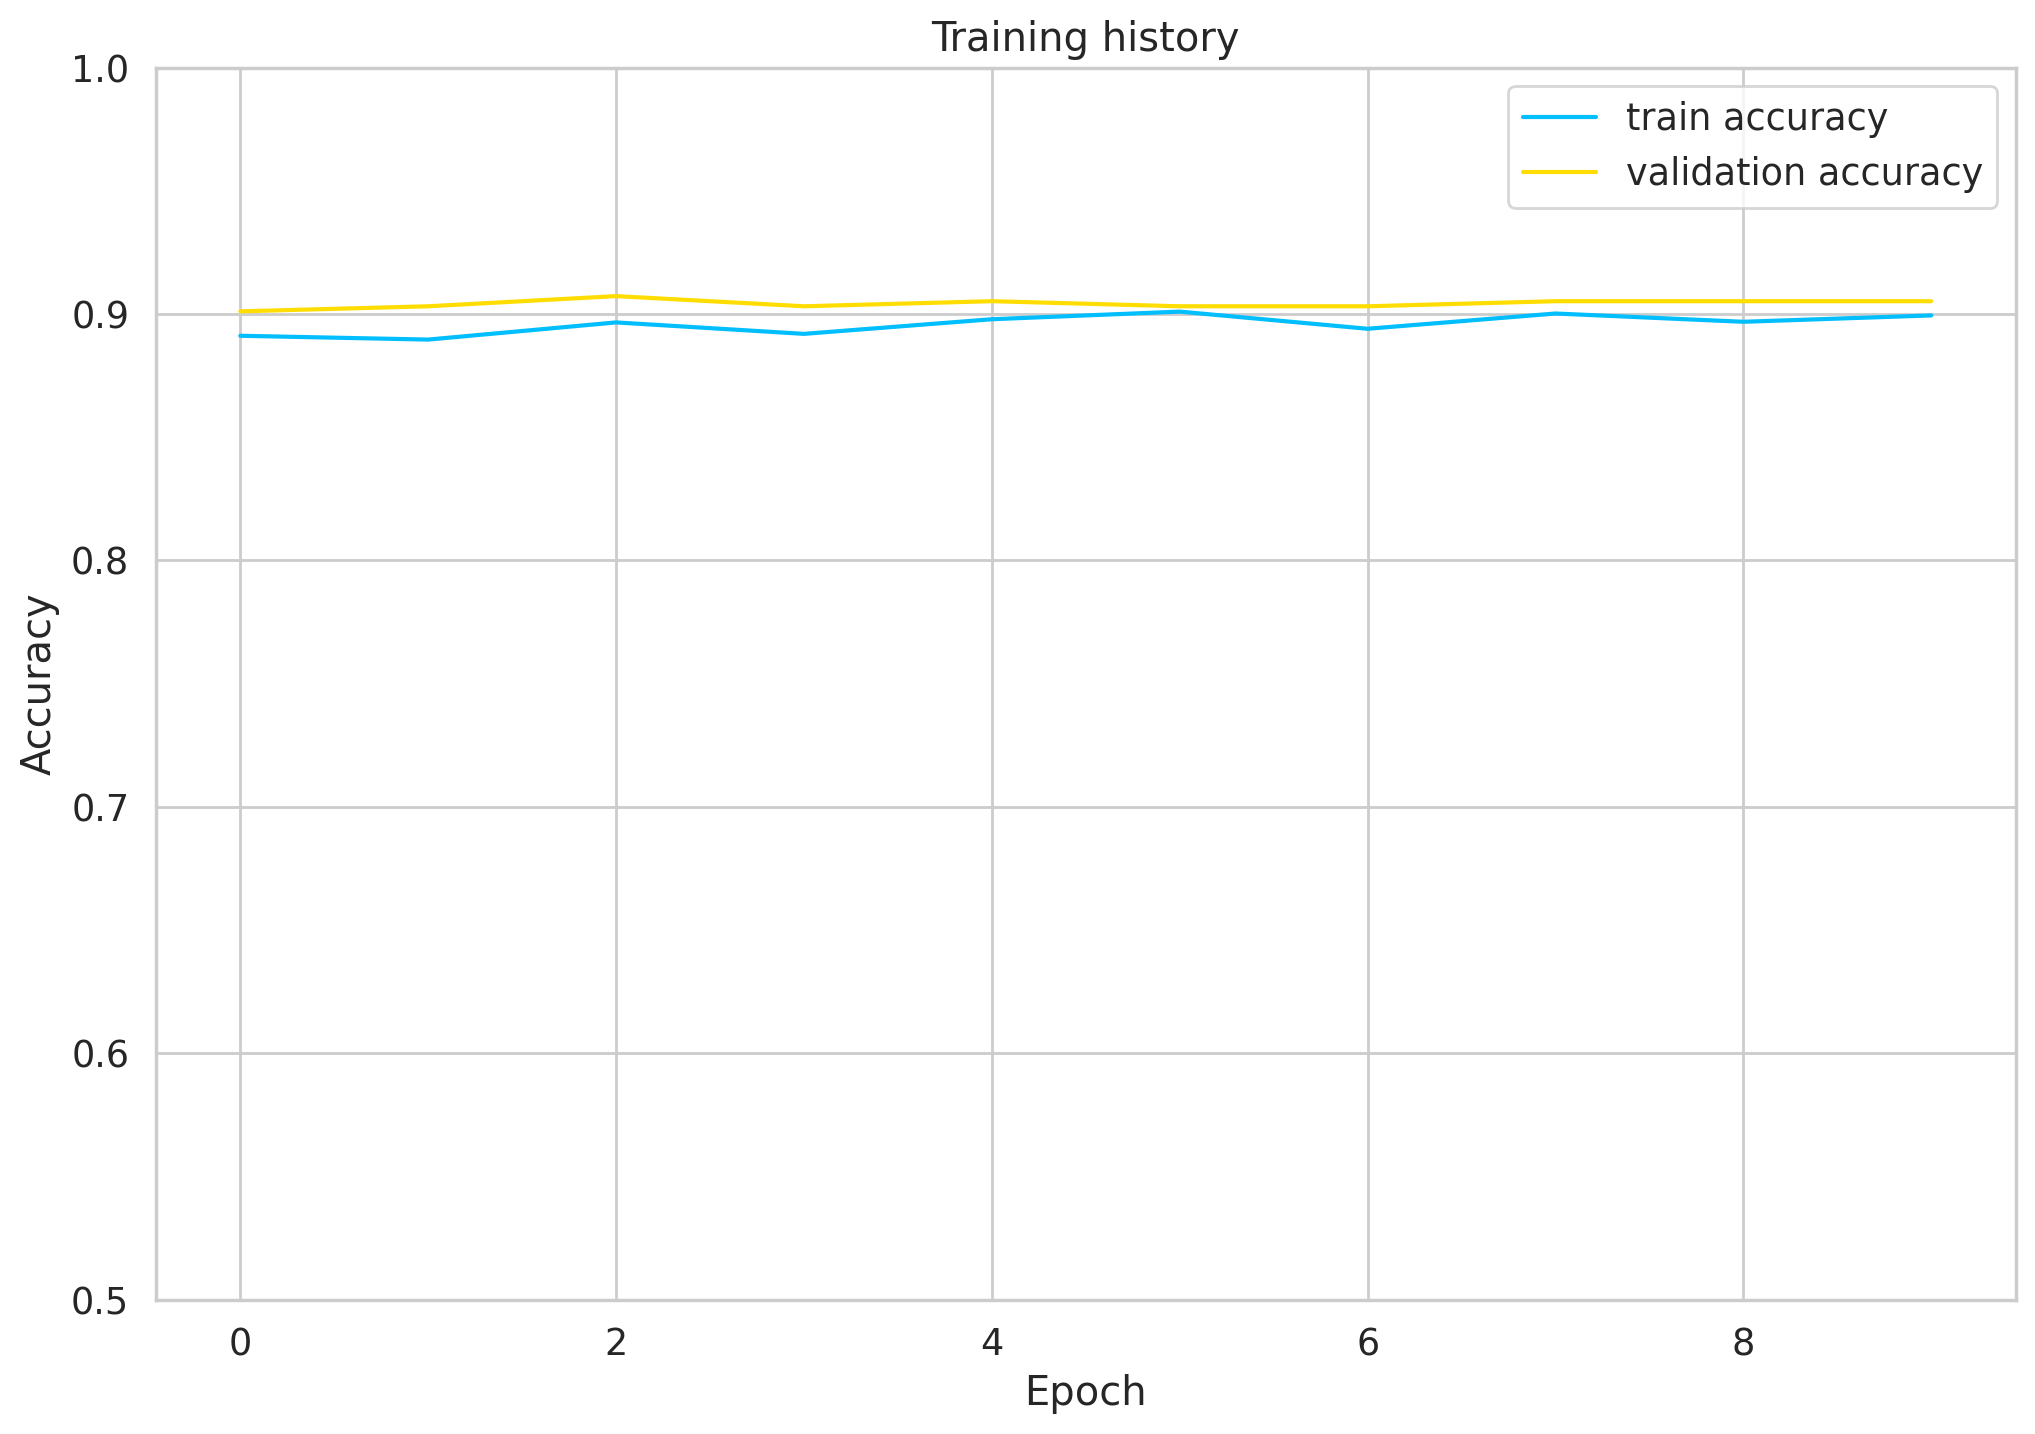

In [42]:
print(history['train_acc'])
print(history['val_acc'])

new_tensor = torch.tensor(history['train_acc'], device = 'cpu')
print(new_tensor)

plt.plot(new_tensor, label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);

In [43]:
# calculating the accuracy on the test data
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9092783505154639

In [44]:
# This is similar to the evaluation function,
# except that we're storing the text and the predicted probabilities
# (by applying the softmax on the model outputs)

def get_predictions(model, data_loader):
  model = model.eval()

  financiar_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["financiar_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      financiar_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return financiar_texts, predictions, prediction_probs, real_values

In [45]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [46]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.92      0.96      0.94        56
     neutral       0.94      0.90      0.92       285
    positive       0.84      0.90      0.87       144

    accuracy                           0.91       485
   macro avg       0.90      0.92      0.91       485
weighted avg       0.91      0.91      0.91       485



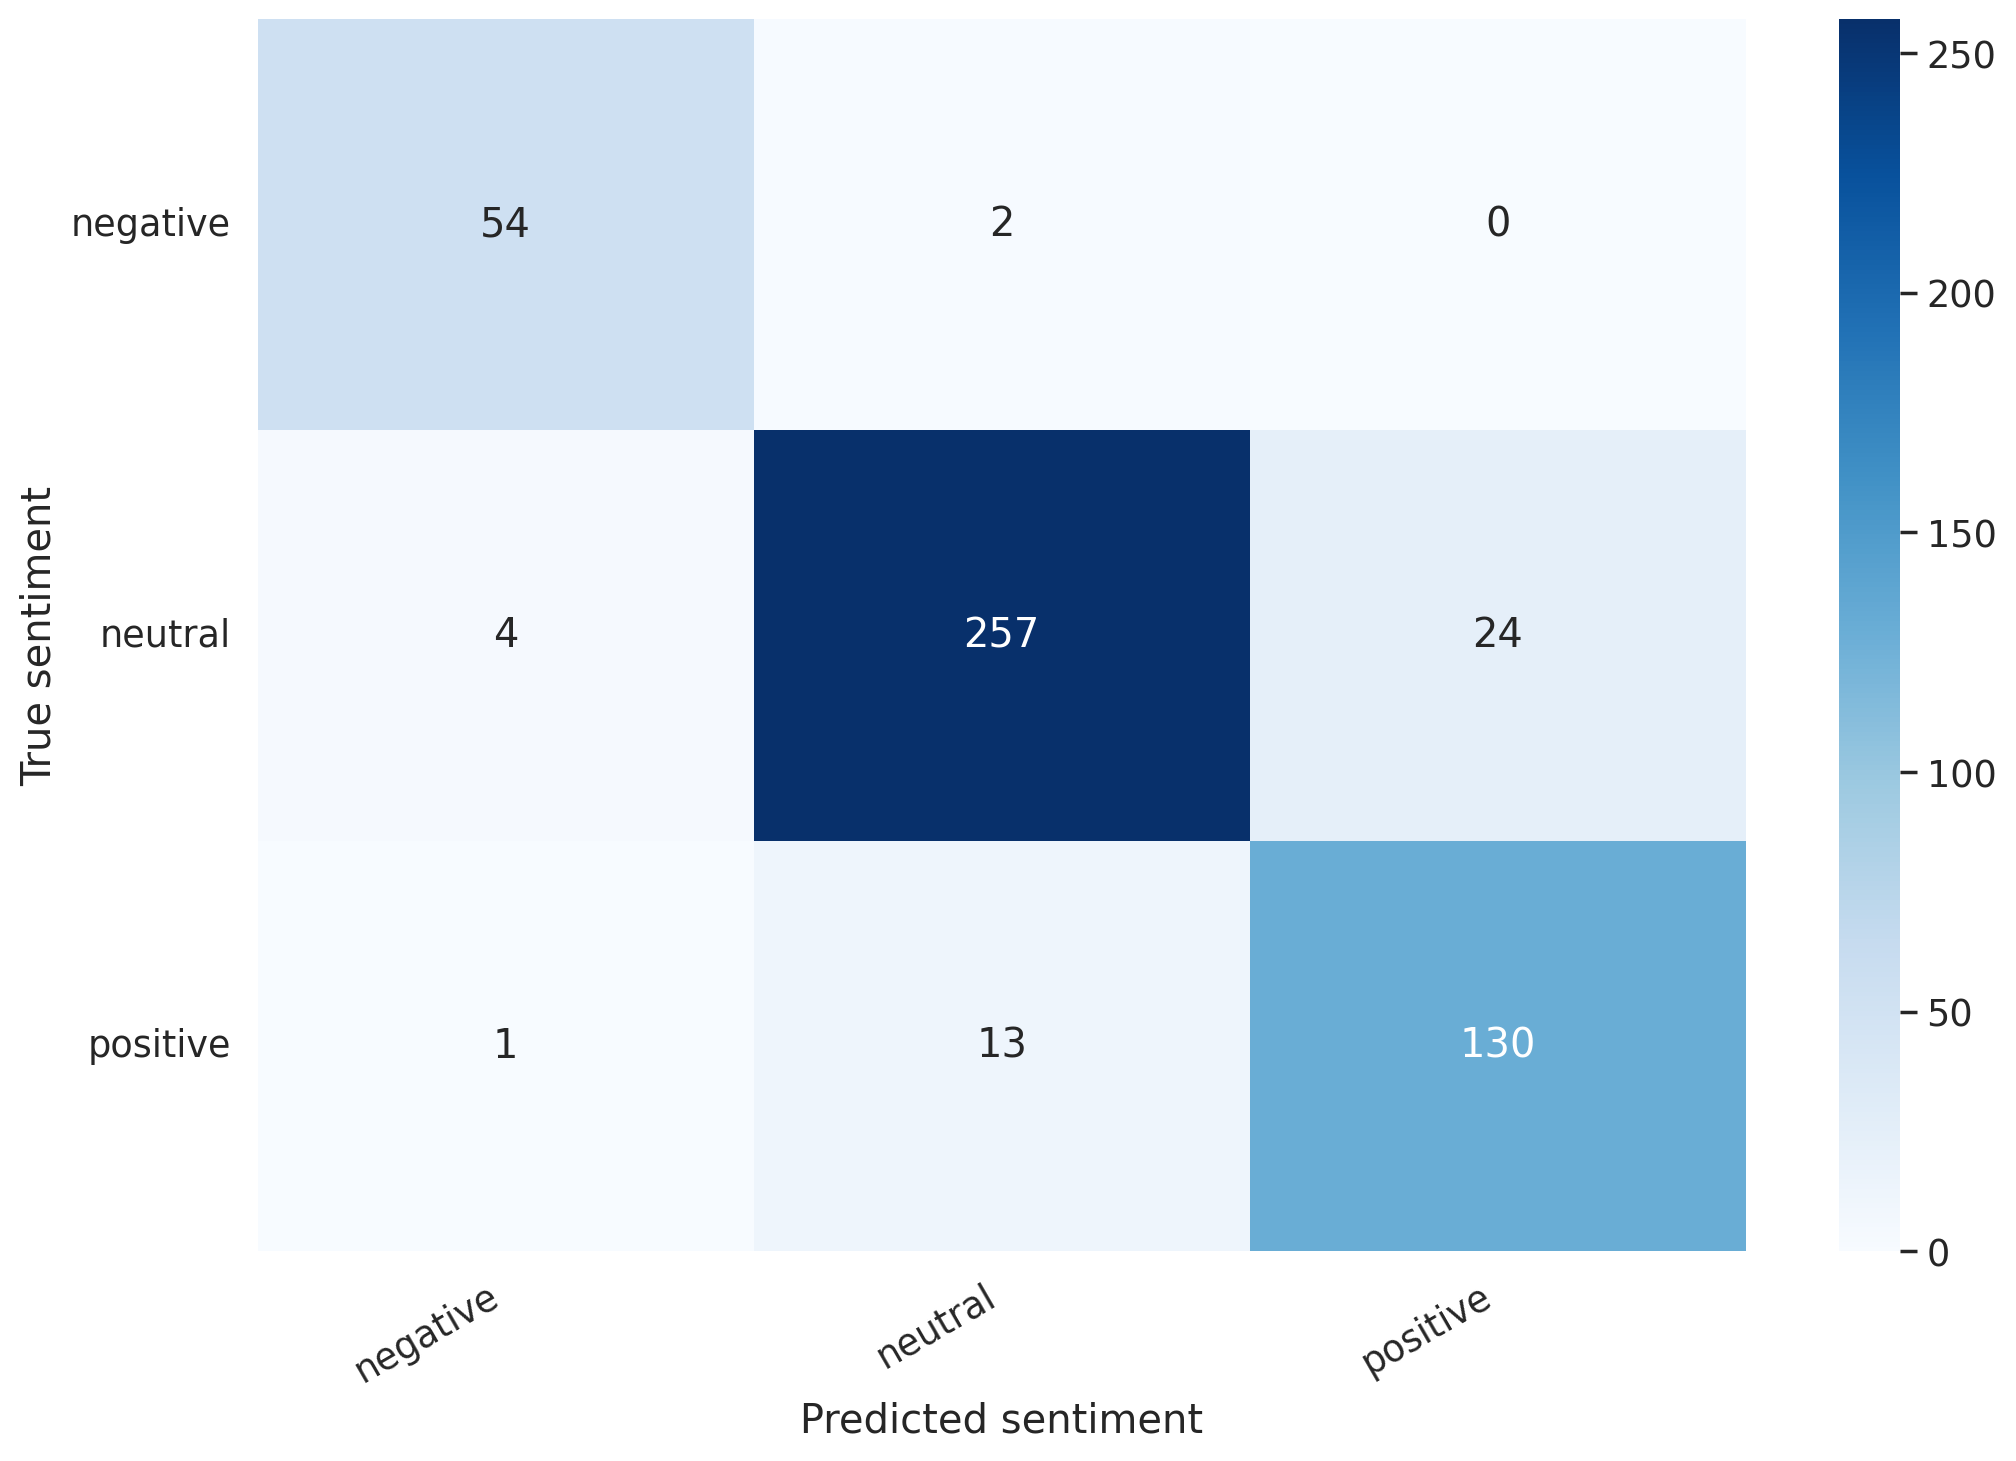

In [47]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [48]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [49]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

As the world leaders in developing UV technology for municipal
wastewater , drinking water , and industrial water treatment systems ,
Trojan Technologies was a logical partner in providing W+Ærtsil+Æ with
UV technology for ballast water treatment .

True sentiment: neutral


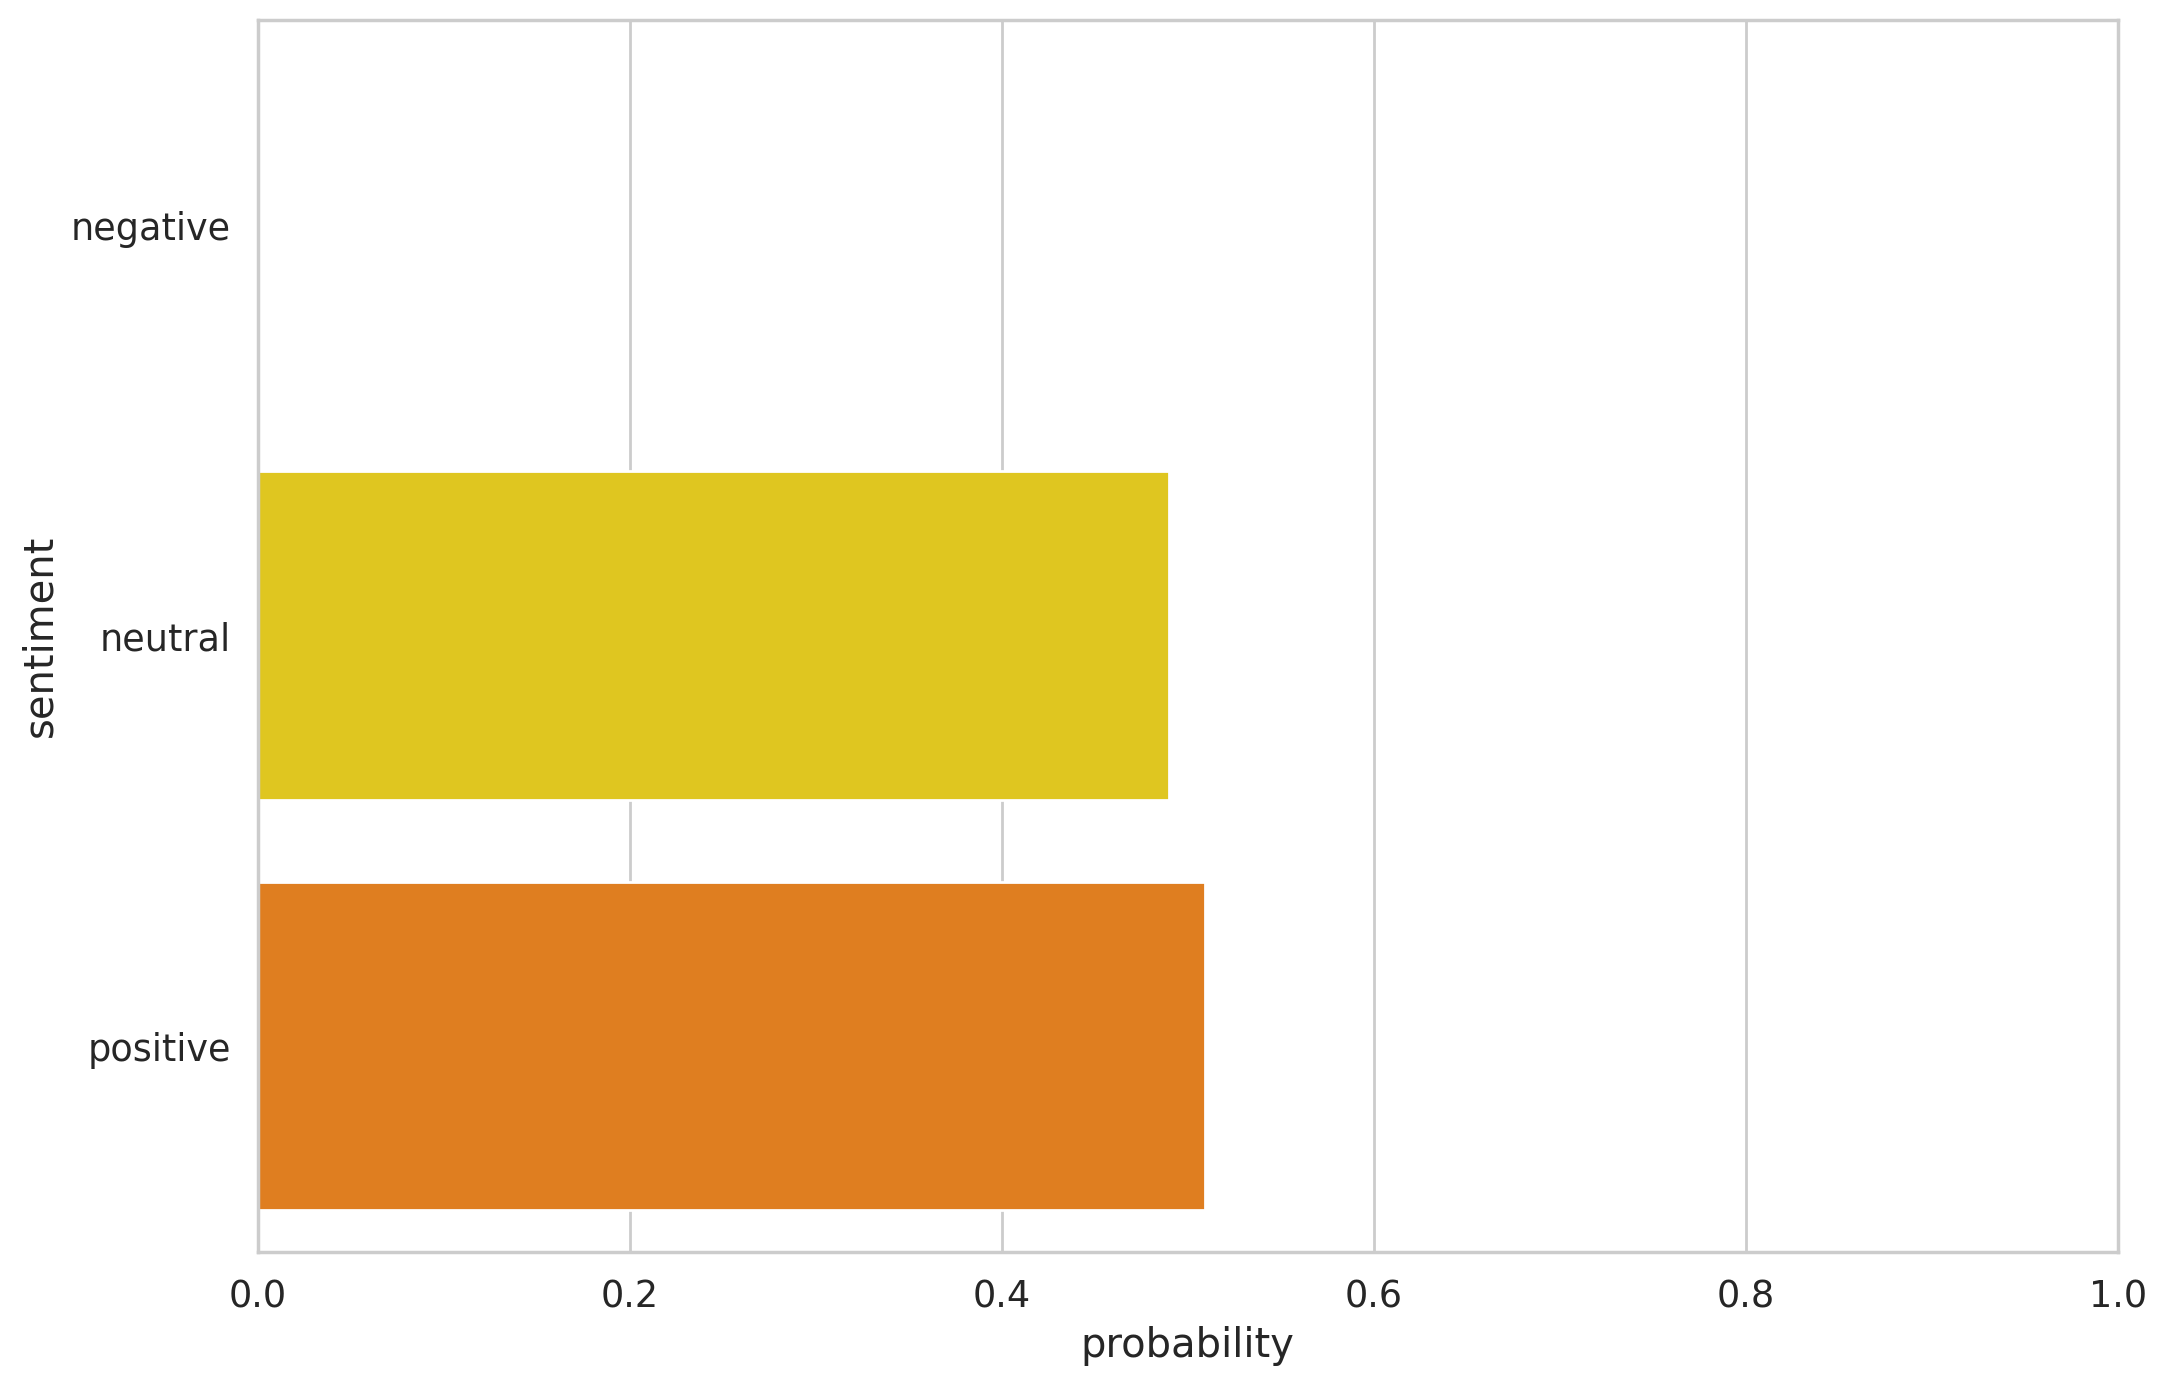

In [50]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [63]:
review_text = "Its poor domestic consumer prices."

In [64]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding = 'max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [65]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Its poor domestic consumer prices.
Sentiment  : negative
